<a href="https://colab.research.google.com/github/AlbertoRoldanSastre/AlbertoRoldanSastre/blob/main/pipeline_YOLOGO_6_4_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PIPELINE COMPLETA CHATGPT



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
################################IMPORTAR EL dataset entero a colab UNA VEZ TIENES LA ESTRUCTURA  ####################################################
####################################################################################


# Copiar el archivo data.yaml desde Drive a la ruta deseada en Colab
!cp -r "/content/drive/MyDrive/v46_6_4_2025" "/content/dataset/"

# Verificar que se copió correctamente
!ls -l "/content/dataset"

total 24
-rw------- 1 root root  257 Apr  6 22:27 data.yaml
-rw------- 1 root root  127 Apr  6 22:27 README.dataset.txt
-rw------- 1 root root  947 Apr  6 22:27 README.roboflow.txt
drwx------ 4 root root 4096 Apr  6 22:28 test
drwx------ 4 root root 4096 Apr  6 22:32 train
drwx------ 4 root root 4096 Apr  6 22:33 valid


In [3]:
!pip install opencv-python-headless albumentations

In [4]:
# full_pipeline_colab.py (versión todo-en-uno, sin imports internos)


import os
import cv2
import albumentations as A
import random
import shutil
import numpy as np





# ------------------------------------
# CONFIGURACIÓN (editable)
# ------------------------------------
BASE_DATASET_DIR = "/content/dataset"
EXPORT_DIR = "/content/export_yolov8"  # Carpeta destino local (Colab)
IMAGE_EXTENSIONS = (".jpg", ".jpeg", ".png")
# Parámetros para tiling

TILE_SIZE = 640               # Por ejemplo, tamaño deseado de cada tile
OVERLAP = 128                 # Overlap en píxeles entre tiles


# Parámetros para el splitting de negativos y augmentación:

NEGATIVE_MULTIPLIER = 6  # 1 positiva : 5 negativas (ratio 1/6 total) # Ej: 1 positiva : 10 negativas
AUGMENTATIONS_MIN = 4
AUGMENTATIONS_MAX = 6


# Rutas para el data.yaml:

# Ruta al archivo data.yaml original (de entrada)
INPUT_YAML_PATH = os.path.join(BASE_DATASET_DIR, "data.yaml")              #puede ser : (BASE_DATASET_DIR, "ready", "data.yaml")  si tienes el data yaml dentro de la carpeta base, luego carpeta ready y luedo dta yaml

# Ruta destino dentro del export final
EXPORT_YAML_PATH = os.path.join(EXPORT_DIR, "data.yaml")

# ------------------------------------
# CONTROL DE LIMPIEZA INTERMEDIA
# ------------------------------------
CLEAN_INTERMEDIATE = False  # Elimina carpetas intermedias después del split




# ------------------------------------
# 1. CONVERTIR LABELS: Polígono → Bounding Box
# ------------------------------------
def polygon_to_bbox(coords):
    xs = coords[0::2]
    ys = coords[1::2]
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)
    return (x_min + x_max) / 2, (y_min + y_max) / 2, x_max - x_min, y_max - y_min

def process_label_file(src_file, dst_file):
    with open(src_file, 'r') as f_in:
        lines = f_in.readlines()
    new_lines = []
    for line in lines:
        parts = line.strip().split()
        if not parts:
            continue
        cls = parts[0]
        coords = list(map(float, parts[1:]))
        if len(coords) == 4:
            new_line = f"{cls} {' '.join(f'{c:.16f}' for c in coords)}"
        else:
            x_center, y_center, width, height = polygon_to_bbox(coords)
            new_line = f"{cls} {x_center:.16f} {y_center:.16f} {width:.16f} {height:.16f}"
        new_lines.append(new_line)
    with open(dst_file, 'w') as f_out:
        for new_line in new_lines:
            f_out.write(new_line + "\n")

def process_all_labels_for_set(set_name):
    print(f"\n🔄 Convirtiendo etiquetas de {set_name.upper()}...")
    src_dir = os.path.join(BASE_DATASET_DIR, set_name, "labels")
    dst_dir = os.path.join(BASE_DATASET_DIR, set_name, "bblabels")
    os.makedirs(dst_dir, exist_ok=True)
    for filename in os.listdir(src_dir):
        if filename.endswith(".txt"):
            process_label_file(os.path.join(src_dir, filename), os.path.join(dst_dir, filename))
    print(f"✅ [{set_name.upper()}] Conversión de etiquetas completada.")

# ------------------------------------
# 2. TILING y Separación Positivos/Negativos
# ------------------------------------
def load_annotations(label_path, image_width, image_height):
    annotations = []
    if not os.path.exists(label_path):
        return annotations
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            cls = parts[0]
            coords = list(map(float, parts[1:]))
            if len(coords) == 4:
                # Se asume formato YOLO: x_center, y_center, w, h (normalizado)
                x_center, y_center, w, h = coords
                x1 = (x_center - w/2) * image_width
                y1 = (y_center - h/2) * image_height
                x2 = (x_center + w/2) * image_width
                y2 = (y_center + h/2) * image_height
            else:
                xs = coords[0::2]
                ys = coords[1::2]
                x1, x2 = min(xs) * image_width, max(xs) * image_width
                y1, y2 = min(ys) * image_height, max(ys) * image_height
            annotations.append((cls, x1, y1, x2, y2))
    return annotations

def adjust_annotation_for_tile(annotation, tile_x, tile_y, tile_size):
    """
    Ajusta una anotación (coordenadas absolutas de la imagen) al sistema de coordenadas locales
    del tile y la normaliza al rango [0,1]. Si la intersección es insuficiente, retorna None.
    """
    cls, x1, y1, x2, y2 = annotation
    # Calcular la intersección entre la caja y el tile
    inter_x1 = max(x1, tile_x)
    inter_y1 = max(y1, tile_y)
    inter_x2 = min(x2, tile_x + tile_size)
    inter_y2 = min(y2, tile_y + tile_size)
    if inter_x2 <= inter_x1 or inter_y2 <= inter_y1:
        return None
    # Coordenadas locales dentro del tile
    local_x1 = inter_x1 - tile_x
    local_y1 = inter_y1 - tile_y
    local_x2 = inter_x2 - tile_x
    local_y2 = inter_y2 - tile_y
    w = local_x2 - local_x1
    h = local_y2 - local_y1
    x_center = local_x1 + w / 2
    y_center = local_y1 + h / 2
    norm_x = x_center / tile_size
    norm_y = y_center / tile_size
    norm_w = w / tile_size
    norm_h = h / tile_size
    # Forzamos que los valores queden en [0,1] (para evitar errores de precisión)
    norm_x = max(0.0, min(1.0, norm_x))
    norm_y = max(0.0, min(1.0, norm_y))
    norm_w = max(0.0, min(1.0, norm_w))
    norm_h = max(0.0, min(1.0, norm_h))
    MIN_SIZE = 0.01
    if norm_w < MIN_SIZE or norm_h < MIN_SIZE:
        return None
    return (cls, norm_x, norm_y, norm_w, norm_h)

def tile_and_separate(image_path, label_path, out_pos_img, out_pos_lbl, out_neg_img, out_neg_lbl, split_name="unknown"):
    image = cv2.imread(image_path)
    if image is None:
        return 0, 0
    orig_h, orig_w = image.shape[:2]
    annotations = load_annotations(label_path, orig_w, orig_h)
    step = TILE_SIZE - OVERLAP
    count_pos, count_neg = 0, 0
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    tile_idx = 0

    # Directorio y archivo de log para tiles descartados
    log_dir = os.path.join(EXPORT_DIR, "errors")
    os.makedirs(log_dir, exist_ok=True)
    log_path = os.path.join(log_dir, "tiles_descartados.txt")
    discard_entries = []

    for y in range(0, orig_h, step):
        for x in range(0, orig_w, step):
            tile = image[y:min(y+TILE_SIZE, orig_h), x:min(x+TILE_SIZE, orig_w)]
            if tile.shape[0] < TILE_SIZE or tile.shape[1] < TILE_SIZE:
                padded = np.zeros((TILE_SIZE, TILE_SIZE, 3), dtype=tile.dtype)
                padded[0:tile.shape[0], 0:tile.shape[1]] = tile
                tile = padded

            tile_name = f"{base_name}_tile_{tile_idx}.jpg"
            label_name = f"{base_name}_tile_{tile_idx}.txt"
            tile_idx += 1

            total_annotations = len(annotations)
            valid_annots = []
            for ann in annotations:
                result = adjust_annotation_for_tile(ann, x, y, TILE_SIZE)
                if result:
                    valid_annots.append(result)

            num_valid = len(valid_annots)
            num_descartadas = total_annotations - num_valid

            if valid_annots:
                cv2.imwrite(os.path.join(out_pos_img, tile_name), tile)
                with open(os.path.join(out_pos_lbl, label_name), 'w') as f:
                    for cls, xc, yc, w, h in valid_annots:
                        f.write(f"{cls} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")
                count_pos += 1
            else:
                print(f"⚠️ Todas las cajas descartadas en {tile_name} ({num_descartadas}/{total_annotations})")
                cv2.imwrite(os.path.join(out_neg_img, tile_name), tile)
                open(os.path.join(out_neg_lbl, label_name), 'w').close()
                count_neg += 1
                discard_entries.append(
                    f"{tile_name} | de {base_name} @ x={x}, y={y} → {total_annotations} cajas, 0 válidas, {num_descartadas} descartadas"
                )

    if discard_entries:
        with open(log_path, "a") as log:
            log.write(f"\n🔹 DESCARTES EN {split_name.upper()}\n")
            log.write("-" * 50 + "\n")
            for entry in discard_entries:
                log.write(entry + "\n")
            log.write(f"\n🔸 TOTAL TILES DESCARTADOS EN {split_name.upper()}: {len(discard_entries)}\n")

    return count_pos, count_neg

def process_tiling_for_set(set_name):
    print(f"\n📦 Procesando tiling para {set_name.upper()}...")
    input_img_dir = os.path.join(BASE_DATASET_DIR, set_name, "images")
    input_lbl_dir = os.path.join(BASE_DATASET_DIR, set_name, "bblabels")
    pos_img = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "positives", "images")
    pos_lbl = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "positives", "labels")
    neg_img = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "negatives", "images")
    neg_lbl = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "negatives", "labels")
    os.makedirs(pos_img, exist_ok=True)
    os.makedirs(pos_lbl, exist_ok=True)
    os.makedirs(neg_img, exist_ok=True)
    os.makedirs(neg_lbl, exist_ok=True)

    image_files = [f for f in os.listdir(input_img_dir) if f.lower().endswith(IMAGE_EXTENSIONS)]
    total_pos, total_neg = 0, 0
    for img_file in image_files:
        img_path = os.path.join(input_img_dir, img_file)
        lbl_path = os.path.join(input_lbl_dir, os.path.splitext(img_file)[0] + ".txt")
        pos, neg = tile_and_separate(img_path, lbl_path, pos_img, pos_lbl, neg_img, neg_lbl, split_name=set_name.upper())
        total_pos += pos
        total_neg += neg
    print(f"✅ {set_name.upper()}: {total_pos} tiles positivos, {total_neg} negativos")



# ------------------------------------
# 3. DATA AUGMENTATION (solo positivos de train)
# ------------------------------------


def read_yolo_labels(label_path):
    bboxes, classes = [], []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    classes.append(parts[0])
                    bboxes.append(list(map(float, parts[1:])))
    return bboxes, classes

transform_pipeline = A.Compose([
    A.SomeOf([
        A.HorizontalFlip(p=1.0),
        A.Rotate(limit=(-5, 5), p=1.0),
        A.Affine(shear=(-5, 5), p=1.0),
        A.RandomBrightnessContrast(brightness_limit=(-0.05, 0.05), contrast_limit=(-0.05, 0.05), p=1.0),
        A.Blur(blur_limit=5, p=1.0),
        A.CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8)),
        A.ToGray(p=0.01, num_output_channels=3, method='weighted_average'),
    ], n=4, replace=True),
    A.Resize(TILE_SIZE, TILE_SIZE)
], bbox_params=A.BboxParams(format='yolo', label_fields=['labels']))

def augment_positives():
    input_img_dir = os.path.join(BASE_DATASET_DIR, "train", "tiles", "positives", "images")
    input_lbl_dir = os.path.join(BASE_DATASET_DIR, "train", "tiles", "positives", "labels")
    output_img_dir = os.path.join(BASE_DATASET_DIR, "train", "tiles", "aug", "positives", "images")
    output_lbl_dir = os.path.join(BASE_DATASET_DIR, "train", "tiles", "aug", "positives", "labels")
    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_lbl_dir, exist_ok=True)
    for filename in os.listdir(input_img_dir):
        if not filename.lower().endswith(IMAGE_EXTENSIONS): continue
        img_path = os.path.join(input_img_dir, filename)
        label_path = os.path.join(input_lbl_dir, os.path.splitext(filename)[0] + ".txt")
        bboxes, classes = read_yolo_labels(label_path)
        if len(bboxes) == 0: continue
        shutil.copy2(img_path, os.path.join(output_img_dir, filename))
        shutil.copy2(label_path, os.path.join(output_lbl_dir, os.path.splitext(filename)[0] + ".txt"))
        num_variants = random.randint(AUGMENTATIONS_MIN, AUGMENTATIONS_MAX)
        for i in range(num_variants):
            image_bgr = cv2.imread(img_path)
            if image_bgr is None: continue
            image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
            try:
                result = transform_pipeline(image=image_rgb, bboxes=bboxes, labels=classes)
            except Exception as e:
                print(f"Error en {filename}: {e}"); continue
            aug_img_rgb = result["image"]
            aug_bboxes = result["bboxes"]
            aug_img_bgr = cv2.cvtColor(aug_img_rgb, cv2.COLOR_RGB2BGR)
            new_img_name = f"{os.path.splitext(filename)[0]}_aug{i}.jpg"
            new_lbl_name = f"{os.path.splitext(filename)[0]}_aug{i}.txt"
            cv2.imwrite(os.path.join(output_img_dir, new_img_name), aug_img_bgr)
            with open(os.path.join(output_lbl_dir, new_lbl_name), 'w') as f:
                for cls, bbox in zip(classes, aug_bboxes):
                    f.write(f"{cls} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
    print("✅ Augmentación completada para positivos de TRAIN.")


# ------------------------------------
# 4. SPLIT DE NEGATIVOS 1/X + RESTO
# ------------------------------------

def split_negatives(set_name, neg_dir="tiles/negatives"):
    # Para TRAIN usamos los positivos *augmentados*, en otros sets usamos los originales
    if set_name == "train":
        pos_dir = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "aug", "positives", "images")
    else:
        pos_dir = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "positives", "images")

    neg_img_dir = os.path.join(BASE_DATASET_DIR, set_name, neg_dir, "images")
    neg_lbl_dir = os.path.join(BASE_DATASET_DIR, set_name, neg_dir, "labels")

    split_base = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "split") if set_name == "train" else os.path.join(BASE_DATASET_DIR, set_name, "tiles")
    dest_1ofx_img = os.path.join(split_base, "negatives_1ofX", "images")
    dest_1ofx_lbl = os.path.join(split_base, "negatives_1ofX", "labels")
    dest_rest_img = os.path.join(split_base, "negatives_rest", "images")
    dest_rest_lbl = os.path.join(split_base, "negatives_rest", "labels")

    os.makedirs(dest_1ofx_img, exist_ok=True)
    os.makedirs(dest_1ofx_lbl, exist_ok=True)
    os.makedirs(dest_rest_img, exist_ok=True)
    os.makedirs(dest_rest_lbl, exist_ok=True)

    # Contar positivos reales (los que van a exportación)
    num_pos = len([f for f in os.listdir(pos_dir) if f.lower().endswith(IMAGE_EXTENSIONS)])
    neg_images = sorted([f for f in os.listdir(neg_img_dir) if f.lower().endswith(IMAGE_EXTENSIONS)])
    num_neg_needed = NEGATIVE_MULTIPLIER * num_pos

    selected = set(neg_images[:num_neg_needed])
    for fname in neg_images:
        src_img = os.path.join(neg_img_dir, fname)
        src_lbl = os.path.join(neg_lbl_dir, os.path.splitext(fname)[0] + ".txt")
        if fname in selected:
            shutil.copy2(src_img, os.path.join(dest_1ofx_img, fname))
            shutil.copy2(src_lbl, os.path.join(dest_1ofx_lbl, os.path.splitext(fname)[0] + ".txt"))
        else:
            shutil.copy2(src_img, os.path.join(dest_rest_img, fname))
            shutil.copy2(src_lbl, os.path.join(dest_rest_lbl, os.path.splitext(fname)[0] + ".txt"))

    if CLEAN_INTERMEDIATE:
        shutil.rmtree(os.path.join(BASE_DATASET_DIR, set_name, neg_dir))
        if set_name == "train":
            shutil.rmtree(os.path.join(BASE_DATASET_DIR, set_name, "tiles", "positives"))

    print(f"✅ {set_name.upper()}: Negativos divididos en 1ofX y resto.")


# ------------------------------------
# 5. RESUMEN FINAL DE IMÁGENES Y LABELS
# ------------------------------------



def count_files(folder):
    if not os.path.exists(folder):
        return 0
    return len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])


def summary():
    print("\n📊 RESUMEN FINAL DE TILES")

    for split in ["train", "valid", "test"]:
        print(f"\n📁 {split.upper()}")
        base = os.path.join(BASE_DATASET_DIR, split, "tiles")

        if split == "train":
            orig_pos = os.path.join(base, "positives")
            aug_pos = os.path.join(base, "aug", "positives")

            orig_img_count = count_files(os.path.join(orig_pos, "images"))
            orig_lbl_count = count_files(os.path.join(orig_pos, "labels"))
            aug_img_count = count_files(os.path.join(aug_pos, "images"))
            aug_lbl_count = count_files(os.path.join(aug_pos, "labels"))

            print(f"Positivos originales: {orig_img_count} imágenes | {orig_lbl_count} etiquetas")
            print(f"Positivos augmentados: {aug_img_count} imágenes | {aug_lbl_count} etiquetas")

            neg_1ofx = os.path.join(base, "split", "negatives_1ofX")
            neg_rest = os.path.join(base, "split", "negatives_rest")
        else:
            pos = os.path.join(base, "positives")
            pos_img_count = count_files(os.path.join(pos, "images"))
            pos_lbl_count = count_files(os.path.join(pos, "labels"))
            print(f"Positivos           : {pos_img_count} imágenes | {pos_lbl_count} etiquetas")

            neg_1ofx = os.path.join(base, "negatives_1ofX")
            neg_rest = os.path.join(base, "negatives_rest")

        # Negativos (común para todos)
        n1x_img = count_files(os.path.join(neg_1ofx, "images"))
        n1x_lbl = count_files(os.path.join(neg_1ofx, "labels"))
        rest_img = count_files(os.path.join(neg_rest, "images"))
        rest_lbl = count_files(os.path.join(neg_rest, "labels"))

        print(f"Neg 1ofX            : {n1x_img} imágenes | {n1x_lbl} etiquetas")
        print(f"Neg resto           : {rest_img} imágenes | {rest_lbl} etiquetas")



# ------------------------------------
# 6. EXPORT FINAL PARA ENTRENAMIENTO YOLOv8
# ------------------------------------



def safe_copy(src_dir, dst_dir, extensions=None):
    copied = 0
    for fname in os.listdir(src_dir):
        if extensions and not fname.lower().endswith(extensions):
            continue
        src = os.path.join(src_dir, fname)
        dst = os.path.join(dst_dir, fname)

        # Evita sobreescribir archivos ya existentes
        if os.path.exists(dst):
            base, ext = os.path.splitext(fname)
            i = 1
            while os.path.exists(os.path.join(dst_dir, f"{base}_{i}{ext}")):
                i += 1
            dst = os.path.join(dst_dir, f"{base}_{i}{ext}")

        shutil.copy2(src, dst)
        copied += 1
    return copied


def export_for_yolov8(base_dataset_dir, export_dir):
    sets = ["train", "valid", "test"]
    os.makedirs(export_dir, exist_ok=True)

    print("\n📦 Iniciando export final para entrenamiento YOLOv8...\n")

    for split in sets:
        print(f"🔄 Procesando {split.upper()}...")

        split_dir = os.path.join(export_dir, split)
        images_dir = os.path.join(split_dir, "images")
        labels_dir = os.path.join(split_dir, "labels")
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(labels_dir, exist_ok=True)

        if split == "train":
            img_src_pos = os.path.join(base_dataset_dir, split, "tiles", "aug", "positives", "images")
            lbl_src_pos = os.path.join(base_dataset_dir, split, "tiles", "aug", "positives", "labels")
            img_src_neg = os.path.join(base_dataset_dir, split, "tiles", "split", "negatives_1ofX", "images")
            lbl_src_neg = os.path.join(base_dataset_dir, split, "tiles", "split", "negatives_1ofX", "labels")
        else:
            img_src_pos = os.path.join(base_dataset_dir, split, "tiles", "positives", "images")
            lbl_src_pos = os.path.join(base_dataset_dir, split, "tiles", "positives", "labels")
            img_src_neg = os.path.join(base_dataset_dir, split, "tiles", "negatives_1ofX", "images")
            lbl_src_neg = os.path.join(base_dataset_dir, split, "tiles", "negatives_1ofX", "labels")

        count_imgs = 0
        count_lbls = 0

        count_imgs += safe_copy(img_src_pos, images_dir, IMAGE_EXTENSIONS)
        count_imgs += safe_copy(img_src_neg, images_dir, IMAGE_EXTENSIONS)
        count_lbls += safe_copy(lbl_src_pos, labels_dir, (".txt",))
        count_lbls += safe_copy(lbl_src_neg, labels_dir, (".txt",))

        print(f"✅ {split.upper()}: {count_imgs} imágenes, {count_lbls} labels exportados.")

    print(f"\n🚀 Export final completo en: {export_dir}")




# ------------------------------------
#  7 SUMMARY DE EXPORT  : Resumen de todo lo movido
# ------------------------------------
def summary_export():
    print("\n📦 EXPORT FINAL PARA YOLOv8")
    for split in ["train", "valid", "test"]:
        exp_img = os.path.join(EXPORT_DIR, split, "images")
        exp_lbl = os.path.join(EXPORT_DIR, split, "labels")
        exp_img_count = count_files(exp_img)
        exp_lbl_count = count_files(exp_lbl)
        print(f"{split.upper():<7}: {exp_img_count} imágenes | {exp_lbl_count} etiquetas")



# ------------------------------------
# 8 Mover el DATAYAML: Mueve data yaml de carpeta original a final para correr el train
# ------------------------------------

def move_data_yaml_to_export(source_path, dest_path):
    if not os.path.exists(source_path):
        print(f"❌ No se encontró el archivo de entrada: {source_path}")
        return
    os.makedirs(os.path.dirname(dest_path), exist_ok=True)
    shutil.copy2(source_path, dest_path)
    print(f"✅ 'data.yaml' copiado a: {dest_path}")



# ------------------------------------
# 9 SUMMARY DE DESCARTESL:
# ------------------------------------


def fix_discard_summary(log_path):
    if not os.path.exists(log_path):
        print("⚠️ No se encontró archivo de descartes.")
        return

    total_global = 0
    resumen_por_split = {}

    with open(log_path, "r") as f:
        lines = f.readlines()

    lines = [line for line in lines if not line.startswith("📦 RESUMEN GLOBAL") and not line.startswith("🔸 ") and not line.startswith("🧮")]

    for line in lines:
        if line.startswith("🔸 TOTAL TILES DESCARTADOS EN"):
            parts = line.strip().split("EN ")
            if len(parts) == 2:
                conjunto_info = parts[1].split(":")
                if len(conjunto_info) == 2:
                    split = conjunto_info[0].strip()
                    cantidad = int(conjunto_info[1].strip())
                    resumen_por_split[split] = cantidad
                    total_global += cantidad

    lines.append("\n📦 RESUMEN GLOBAL DE TILES DESCARTADOS\n")
    lines.append("=".ljust(50, "=") + "\n")
    for split, count in resumen_por_split.items():
        lines.append(f"🔸 {split}: {count} tiles descartados\n")
    lines.append(f"\n🧮 TOTAL GLOBAL DE TILES DESCARTADOS: {total_global}\n")

    with open(log_path, "w") as f:
        f.writelines(lines)

    print("\n📦 RESUMEN GLOBAL DE TILES DESCARTADOS (RECALCULADO)")
    print("=" * 50)
    for split, count in resumen_por_split.items():
        print(f"🔸 {split}: {count} tiles descartados")
    print(f"\n🧮 TOTAL GLOBAL DE TILES DESCARTADOS: {total_global}")



# ------------------------------------
# MAIN PIPELINE: ejecuta todo en orden
# ------------------------------------
def run_full_pipeline():
    for split in ["train", "valid", "test"]:
        process_all_labels_for_set(split)                            # Paso 1: convertir etiquetas
        process_tiling_for_set(split)                                # Paso 2: tiling y separar en positivos/negativos

    augment_positives()                                              # Paso 3: augment solo para train

    for split in ["train", "valid", "test"]:
        split_negatives(split)                                      # Paso 4: dividir negativos en 1/X y resto

    summary()                                                       # Paso 5: mostrar resumen de tiles (con augmentación incluida)
    export_for_yolov8(BASE_DATASET_DIR, EXPORT_DIR)                 # Paso 6: exportar a carpeta lista para YOLOv8

    print("\n📊 RE-CONTANDO DESPUÉS DE EXPORTACIÓN")

    summary_export()                                                # Paso 7: mostrar resumen del set exportado (lo que se entrena realmente)

    move_data_yaml_to_export(INPUT_YAML_PATH, EXPORT_YAML_PATH)     # Paso 8: mover data.yaml al export final

    fix_discard_summary(os.path.join(EXPORT_DIR, "errors", "tiles_descartados.txt"))   # Paso 9: limpiar y recalcular resumen del log






# 🔁 Ejecutar todo:

run_full_pipeline()









Se han truncado las últimas 5000 líneas del flujo de salida.
⚠️ Todas las cajas descartadas en DSC00446_JPG-X-Amz-Algorithm-AWS4-HMAC-SHA256.rf.b1105e1ea282eabe3425b4bba052ceaf_tile_61.jpg (1/1)
⚠️ Todas las cajas descartadas en DSC00446_JPG-X-Amz-Algorithm-AWS4-HMAC-SHA256.rf.b1105e1ea282eabe3425b4bba052ceaf_tile_62.jpg (1/1)
⚠️ Todas las cajas descartadas en DSC00446_JPG-X-Amz-Algorithm-AWS4-HMAC-SHA256.rf.b1105e1ea282eabe3425b4bba052ceaf_tile_63.jpg (1/1)
⚠️ Todas las cajas descartadas en DSC00446_JPG-X-Amz-Algorithm-AWS4-HMAC-SHA256.rf.b1105e1ea282eabe3425b4bba052ceaf_tile_64.jpg (1/1)
⚠️ Todas las cajas descartadas en DSC00446_JPG-X-Amz-Algorithm-AWS4-HMAC-SHA256.rf.b1105e1ea282eabe3425b4bba052ceaf_tile_65.jpg (1/1)
⚠️ Todas las cajas descartadas en DSC00446_JPG-X-Amz-Algorithm-AWS4-HMAC-SHA256.rf.b1105e1ea282eabe3425b4bba052ceaf_tile_66.jpg (1/1)
⚠️ Todas las cajas descartadas en DSC00446_JPG-X-Amz-Algorithm-AWS4-HMAC-SHA256.rf.b1105e1ea282eabe3425b4bba052ceaf_tile_67.jpg (1/1)
⚠

In [ ]:
🧠 Consejo extra:
Si quieres hacer pruebas por bloques, comenta esta línea al final del script:


# run_full_pipeline()

Y luego puedes llamar a cada paso manualmente, como por ejemplo:



process_all_labels_for_set("train")
process_tiling_for_set("train")
augment_positives()
split_negatives("train")
summary()


In [ ]:
Perfecto, Albie. Ahora que tienes todo tu script modular listo, aquí te explico cómo llamar a cada bloque manualmente, por si quieres ejecutar tu pipeline paso a paso:

✅ Ejecutar bloques manualmente
🟡 1. Conversión de etiquetas (segmentación → bounding box)

process_all_labels_for_set("train")
process_all_labels_for_set("valid")
process_all_labels_for_set("test")
🟡 2. Tiling y separación en positivos/negativos

process_tiling_for_set("train")
process_tiling_for_set("valid")
process_tiling_for_set("test")
🟡 3. Data augmentation (solo train)

augment_positives()
🟡 4. División de negativos (1/X y resto)

split_negatives("train")
split_negatives("valid")
split_negatives("test")
🟡 5. Mostrar resumen final

summary()
💡 Consejo
Puedes comentar esta línea si no quieres que todo se ejecute automáticamente al cargar el script:


# run_full_pipeline()

In [ ]:
#!/usr/bin/env python3
import os

def count_annotation_txts(directory):
    total_txt = 0
    annotated_txt = 0
    empty_txt = 0

    for filename in os.listdir(directory):
        if filename.lower().endswith(".txt"):
            total_txt += 1
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as f:
                # Se consideran las líneas que tienen algo de contenido (no solo espacios)
                lines = [line for line in f if line.strip()]
                if lines:
                    annotated_txt += 1
                else:
                    empty_txt += 1

    return total_txt, annotated_txt, empty_txt

if __name__ == '__main__':
    folder = input("Introduce el path de la carpeta a chequear: ").strip()
    if not os.path.isdir(folder):
        print("El path proporcionado no es un directorio válido.")
    else:
        total, annotated, empty = count_annotation_txts(folder)
        print(f"\nTotal de archivos .txt: {total}")
        print(f"Archivos con anotaciones: {annotated}")
        print(f"Archivos vacíos: {empty}")


In [5]:
#0. En Colab, primero instala los paquetes y monta tu Drive:  Instalar las librerías necesarias
!pip install ultralytics wandb  # Esto instalará ultralytics y wandb (torch y torchvision generalmente ya vienen instalados en Colab)

import ultralytics
ultralytics.checks()

Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 52.5/235.7 GB disk)


In [2]:

# 9. Ejecutar el entrenamiento de YOLOv8
from ultralytics import YOLO

# Carga el modelo (en este ejemplo, YOLOv8s)
model = YOLO("yolov8s.pt")

#Add W&B callback for ultralytics:
#add_wandb_callback(model, True, True)


In [3]:
# Ejecuta el entrenamiento utilizando el archivo data.yaml en la carpeta extraída.
model.train(
    project="seals_2025",
    name="focas_prueba_3_4_2025_lr_00005_batch16_adamw_no_mosaic",
    data="/content/export_yolov8/data.yaml",  # Asegúrate de que data.yaml use rutas correctas para Colab
    epochs=100,                                                  # Número total de épocas (pasadas completas por el dataset de entrenamiento)
    imgsz=640,                                                  # Tamaño de la imagen (se reescala a 640x640)
    batch=16,                                                   # Número de imágenes por batch
    lr0=0.001,        #probar 0.0005                            # Tasa de aprendizaje inicial. Un valor mayor hace que los pesos se actualicen más rápido, pero puede inestabilizar el entrenamiento.
    momentum=0.937,                                             # Momentum para el optimizador (por ejemplo, en SGD)
    warmup_momentum=0.8,                                        # La fase de "warmup" es un período inicial en el que la tasa de aprendizaje y otros parámetros (como el momentum) se ajustan gradualmente.    Esto ayuda a estabilizar el entrenamiento y a evitar que el modelo se desvíe demasiado al principio.
    optimizer="adamw",       #otra opcion es = sgd / adamw             # Se usa AdamW (una variante de Adam que incorpora weight decay para evitar sobreajuste)
    weight_decay=0.0005,                                        # Penalización sobre los pesos para prevenir sobreajuste. Si es muy alto, puede dificultar el aprendizaje; si es muy bajo, el modelo puede sobreajustarse.                                          # Se usa AdamW (una variante de Adam que incorpora weight decay para evitar sobreajuste)
    #augment=False,                                             # Desactiva el data augmentation on the fly de YOLO##############  asi puedo hacer yo la data augmentation con las fotos con labels
    half=True,                                                  # Activa precisión mixta (FP16) para GPU
    workers=8,                                                  # Número de workers para el DataLoader
    device='cuda' ,                                            # Fuerza el uso de GPU lo que acelera el entrenamiento
    mosaic=0,                                                  # Desactivar si las imágenes son muy homogéneas, es un data augmentation process
    #resume=True,                                               #PARA seguir entrenamiento donde lo dejaste
    #validate=False                                              # para no hacer validación a la vez que entrena
    patience=7,                                                 # epochs extra desde que converge para ver si aprende , si no aprende en 3 epochs más, se para. si tras "X" epochs la métrica val/best_map_50 no mejora, se detiene el entrenamiento automáticamente.
    cos_lr=True,                                                # scheduler
    plots=True,                                                  #generar gráficas de plots de learning rate
    #wandb=True,                                                  # ✅ Activa integración con W&B

)



Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/export_yolov8/data.yaml, epochs=100, time=None, patience=7, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=seals_2025, name=focas_prueba_3_4_2025_lr_00005_batch16_adamw_no_mosaic2, exist_ok=False, pretrained=True, optimizer=adamw, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=True, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save

100%|██████████| 5.35M/5.35M [00:00<00:00, 336MB/s]


AMP: checks passed ✅


train: Scanning /content/export_yolov8/train/labels... 42336 images, 36347 backgrounds, 0 corrupt: 100%|██████████| 42336/42336 [00:19<00:00, 2173.57it/s]


train: New cache created: /content/export_yolov8/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/export_yolov8/valid/labels... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<00:00, 1890.58it/s]


val: New cache created: /content/export_yolov8/valid/labels.cache
Plotting labels to seals_2025/focas_prueba_3_4_2025_lr_00005_batch16_adamw_no_mosaic2/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to seals_2025/focas_prueba_3_4_2025_lr_00005_batch16_adamw_no_mosaic2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.73G      1.651      2.731     0.9044          0        640: 100%|██████████| 2646/2646 [04:07<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:03<00:00, 12.59it/s]

                   all       1519        262      0.762      0.654      0.737      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.52G      1.619      1.184     0.9008          2        640: 100%|██████████| 2646/2646 [03:51<00:00, 11.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.88it/s]

                   all       1519        262      0.756      0.675      0.757      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.56G      1.541      1.105      0.864          2        640: 100%|██████████| 2646/2646 [03:44<00:00, 11.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.80it/s]

                   all       1519        262      0.741      0.698      0.745      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       4.6G      1.493      1.036     0.8598          4        640: 100%|██████████| 2646/2646 [03:43<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.45it/s]

                   all       1519        262      0.775       0.73       0.76      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.63G      1.427     0.9558     0.8476          1        640: 100%|██████████| 2646/2646 [03:44<00:00, 11.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 17.00it/s]

                   all       1519        262      0.728      0.705      0.781      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.67G       1.39     0.9183     0.8265          1        640: 100%|██████████| 2646/2646 [03:44<00:00, 11.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.86it/s]

                   all       1519        262      0.754      0.779      0.813      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.71G      1.355     0.8797     0.8224          0        640: 100%|██████████| 2646/2646 [03:44<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.67it/s]

                   all       1519        262      0.878      0.733      0.826      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.74G       1.34     0.8563     0.8207          2        640: 100%|██████████| 2646/2646 [03:44<00:00, 11.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.99it/s]

                   all       1519        262      0.822       0.75      0.803      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.78G      1.306     0.8281     0.8103          2        640: 100%|██████████| 2646/2646 [03:45<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.71it/s]

                   all       1519        262      0.858      0.751      0.835      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.81G      1.305     0.8015     0.8187          3        640: 100%|██████████| 2646/2646 [03:45<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 17.14it/s]

                   all       1519        262      0.822      0.785      0.841      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.85G      1.285     0.7902      0.812          3        640: 100%|██████████| 2646/2646 [03:45<00:00, 11.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.91it/s]

                   all       1519        262      0.891      0.785      0.864       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.89G      1.257     0.7825     0.8004          1        640: 100%|██████████| 2646/2646 [03:46<00:00, 11.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.71it/s]

                   all       1519        262      0.869      0.819      0.865      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.92G      1.266     0.7706     0.7946          0        640: 100%|██████████| 2646/2646 [03:47<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.98it/s]

                   all       1519        262      0.867      0.812      0.863      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.96G      1.235     0.7548     0.7918         10        640: 100%|██████████| 2646/2646 [03:45<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.59it/s]

                   all       1519        262      0.868      0.799      0.857      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         5G      1.242     0.7375     0.7965          4        640: 100%|██████████| 2646/2646 [03:46<00:00, 11.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.95it/s]

                   all       1519        262      0.833      0.808      0.868      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.03G      1.192     0.7086     0.7818          0        640: 100%|██████████| 2646/2646 [03:46<00:00, 11.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.64it/s]

                   all       1519        262      0.892      0.782      0.873      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.07G      1.226     0.7218     0.7975          2        640: 100%|██████████| 2646/2646 [03:46<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.82it/s]

                   all       1519        262      0.861      0.781       0.86      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.11G      1.192     0.6999     0.7854          4        640: 100%|██████████| 2646/2646 [03:46<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 17.09it/s]

                   all       1519        262       0.86      0.808      0.871      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.14G      1.188     0.6946     0.7789          2        640: 100%|██████████| 2646/2646 [03:46<00:00, 11.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.91it/s]

                   all       1519        262      0.867      0.831      0.873      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.18G      1.171     0.6683     0.7777          2        640: 100%|██████████| 2646/2646 [03:45<00:00, 11.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 17.15it/s]

                   all       1519        262      0.867      0.838      0.882      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.21G      1.175     0.6591     0.7816          4        640: 100%|██████████| 2646/2646 [03:46<00:00, 11.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.06it/s]

                   all       1519        262      0.846      0.836      0.879      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.25G      1.183     0.6668     0.7935          2        640: 100%|██████████| 2646/2646 [03:46<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 17.16it/s]

                   all       1519        262      0.857      0.814      0.875      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.29G      1.154     0.6485     0.7826          4        640: 100%|██████████| 2646/2646 [03:46<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.42it/s]

                   all       1519        262      0.866      0.811      0.872      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.32G       1.14     0.6553     0.7765          3        640: 100%|██████████| 2646/2646 [03:46<00:00, 11.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.95it/s]

                   all       1519        262      0.861      0.808      0.872      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.36G      1.134     0.6421     0.7758          1        640: 100%|██████████| 2646/2646 [03:46<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.49it/s]

                   all       1519        262      0.867      0.815      0.874       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       5.4G      1.133     0.6284     0.7731          2        640: 100%|██████████| 2646/2646 [03:47<00:00, 11.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.78it/s]

                   all       1519        262      0.866      0.816      0.873      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.43G      1.116     0.6225     0.7708          0        640: 100%|██████████| 2646/2646 [03:48<00:00, 11.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.46it/s]

                   all       1519        262      0.856      0.817      0.872      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.47G      1.107     0.5997     0.7656          1        640: 100%|██████████| 2646/2646 [03:46<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.72it/s]

                   all       1519        262      0.873      0.819      0.873      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.51G      1.087     0.6095     0.7538          3        640: 100%|██████████| 2646/2646 [03:46<00:00, 11.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.50it/s]

                   all       1519        262      0.866      0.825      0.873      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.54G        1.1     0.5993     0.7621          2        640: 100%|██████████| 2646/2646 [03:47<00:00, 11.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.73it/s]

                   all       1519        262      0.874      0.822      0.872      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.58G      1.094     0.5943     0.7628          4        640: 100%|██████████| 2646/2646 [03:47<00:00, 11.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.89it/s]

                   all       1519        262      0.864      0.821      0.873      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.62G       1.08     0.5934     0.7642          4        640: 100%|██████████| 2646/2646 [03:47<00:00, 11.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.82it/s]

                   all       1519        262      0.879      0.819      0.874      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.65G      1.063      0.571     0.7564          6        640: 100%|██████████| 2646/2646 [03:46<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.59it/s]

                   all       1519        262      0.879      0.817      0.873      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.69G      1.062      0.582     0.7515          1        640: 100%|██████████| 2646/2646 [03:47<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 17.09it/s]

                   all       1519        262      0.877      0.806      0.874      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.72G      1.054      0.571     0.7528          0        640: 100%|██████████| 2646/2646 [03:47<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.63it/s]

                   all       1519        262      0.882      0.811      0.873      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.76G       1.05     0.5724     0.7522          6        640: 100%|██████████| 2646/2646 [03:48<00:00, 11.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 17.01it/s]

                   all       1519        262      0.881      0.811      0.873      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       5.8G      1.025     0.5478     0.7431          2        640: 100%|██████████| 2646/2646 [03:46<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.68it/s]

                   all       1519        262      0.879      0.818      0.875      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.87G      1.022      0.561     0.7489          3        640: 100%|██████████| 2646/2646 [03:46<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 16.80it/s]

                   all       1519        262      0.884       0.82      0.875       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       5.9G       1.02     0.5311     0.7474          1        640: 100%|██████████| 2646/2646 [03:47<00:00, 11.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:02<00:00, 17.09it/s]

                   all       1519        262      0.884      0.806      0.871       0.57
EarlyStopping: Training stopped early as no improvement observed in last 7 epochs. Best results observed at epoch 32, best model saved as best.pt.
To update EarlyStopping(patience=7) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



39 epochs completed in 2.497 hours.
Optimizer stripped from seals_2025/focas_prueba_3_4_2025_lr_00005_batch16_adamw_no_mosaic2/weights/last.pt, 22.5MB
Optimizer stripped from seals_2025/focas_prueba_3_4_2025_lr_00005_batch16_adamw_no_mosaic2/weights/best.pt, 22.5MB

Validating seals_2025/focas_prueba_3_4_2025_lr_00005_batch16_adamw_no_mosaic2/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:03<00:00, 15.09it/s]


                   all       1519        262      0.879      0.819      0.874      0.572
                  hole        168        169      0.913      0.874      0.914      0.624
                  seal         85         93      0.846      0.763      0.835       0.52
Speed: 0.2ms preprocess, 0.9ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to seals_2025/focas_prueba_3_4_2025_lr_00005_batch16_adamw_no_mosaic2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79faf9a67ed0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [4]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [7]:
# 10. Guardar los resultados del experimento

# Define la carpeta de destino en Google Drive
dest_folder = "/content/drive/MyDrive/v46_6_4_2025/resultados_epoch39_6_4_2025"
!mkdir -p "{dest_folder}"  # El comando mkdir -p crea esa carpeta (y cualquier subcarpeta necesaria) si no existe.

# Copia la carpeta de resultados (ajusta el nombre según el que se haya generado)
!cp -r /content/seals_2025/focas_prueba_3_4_2025_lr_00005_batch16_adamw_no_mosaic "{dest_folder}/"  # Copiar los resultados del modelo en drive

# Comprueba que se copiaron los archivos (opcional)
!ls "{dest_folder}"

# Opcional: comprimir la carpeta de resultados para descargarla a tu PC
#zip_output_path = "/content/negative_images.zip"  # Ruta temporal para almacenar el archivo ZIP en el entorno de Colab

# Corrige la ruta de compresión para comprimir la carpeta images_negatives correctamente
#!zip -r "{zip_output_path}" "{dest_folder}/images_negatives"  # Aquí se comprime la carpeta que acabas de copiar en Drive (images_negatives) en un archivo ZIP.

# Descargar el archivo ZIP a tu PC
#from google.colab import files
#files.download(zip_output_path)  # Descargar el archivo comprimido                                       #Este comando abre una ventana de descarga para que puedas bajar el archivo ZIP a tu ordenador.

focas_prueba_3_4_2025_lr_00005_batch16_adamw_no_mosaic
focas_prueba_3_4_2025_lr_00005_batch16_adamw_no_mosaic2


In [12]:
# Cargar el modelo entrenado (ajusta la ruta según corresponda)
model = YOLO("/content/seals_2025/focas_prueba_3_4_2025_lr_00005_batch16_adamw_no_mosaic2/weights/best.pt")

# Ejecutar validación especificando el archivo de datos y los umbrales deseados
metrics = model.val(data="/content/export_yolov8/data.yaml", iou=0.40, conf=0.40)

# Mostrar las métricas obtenidas en la validación
print("Métricas de validación:", metrics)


names = {0: 'hole', 1: 'seal'}  # Define tus clases aquí
class_maps = metrics.maps  # metrics.maps es un array, no se llama como función

print("\n=== VALIDACIÓN POR CLASE ===")
for i, (cls_map, name) in enumerate(zip(class_maps, names.values())):
    print(f"{name}: mAP50-95 = {cls_map:.4f}")

Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/export_yolov8/valid/labels.cache... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:04<00:00, 23.39it/s]


                   all       1519        262      0.929      0.702      0.817      0.563
                  hole        168        169      0.935      0.769      0.861      0.611
                  seal         85         93      0.922      0.634      0.774      0.515
Speed: 0.3ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val5
Métricas de validación: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79fd7d67bd50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.01

=== MÉTRICAS GENERALES SOBRE VALIDACIÓN ===
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/export_yolov8/valid/labels.cache... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:04<00:00, 22.37it/s]


                   all       1519        262      0.918      0.757      0.841      0.572
                  hole        168        169      0.932      0.805      0.877       0.62
                  seal         85         93      0.904       0.71      0.806      0.524
Speed: 0.3ms preprocess, 1.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val8
Precision promedio: 0.9178
Recall promedio: 0.7572
mAP@0.5: 0.8413
mAP@0.5:0.95: 0.5718

=== MÉTRICAS POR CLASE EN VALIDACIÓN ===
hole: mAP50-95 = 0.6198
seal: mAP50-95 = 0.5238

=== CURVA DE MÉTRICAS SEGÚN CONFIDENCE (VALIDACIÓN) ===
Evaluando con conf = 0.05
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/valid/labels.cache... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:04<00:00, 23.37it/s]


                   all       1519        262        0.9      0.839      0.877      0.591
Speed: 0.3ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val9
Evaluando con conf = 0.1
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/valid/labels.cache... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:04<00:00, 23.35it/s]


                   all       1519        262      0.907      0.822       0.87      0.587
Speed: 0.3ms preprocess, 1.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val10
Evaluando con conf = 0.15
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/valid/labels.cache... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:04<00:00, 23.16it/s]


                   all       1519        262      0.906      0.798      0.859      0.581
Speed: 0.3ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val11
Evaluando con conf = 0.2
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/valid/labels.cache... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:04<00:00, 23.08it/s]


                   all       1519        262      0.907      0.777      0.849      0.575
Speed: 0.3ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val12
Evaluando con conf = 0.25
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/valid/labels.cache... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:04<00:00, 23.49it/s]


                   all       1519        262      0.918      0.757      0.841      0.572
Speed: 0.3ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val13
Evaluando con conf = 0.3
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/valid/labels.cache... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:04<00:00, 23.20it/s]


                   all       1519        262      0.921      0.727      0.828       0.57
Speed: 0.3ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val14
Evaluando con conf = 0.35
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/valid/labels.cache... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:03<00:00, 23.75it/s]


                   all       1519        262      0.919      0.714      0.821      0.565
Speed: 0.3ms preprocess, 1.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val15
Evaluando con conf = 0.4
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/valid/labels.cache... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:04<00:00, 22.87it/s]


                   all       1519        262      0.929      0.702      0.817      0.563
Speed: 0.3ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val16
Evaluando con conf = 0.45
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/valid/labels.cache... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:04<00:00, 23.16it/s]


                   all       1519        262      0.941      0.679      0.808      0.558
Speed: 0.3ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val17
Evaluando con conf = 0.5
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/valid/labels.cache... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:04<00:00, 23.39it/s]


                   all       1519        262      0.939      0.663        0.8      0.552
Speed: 0.3ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val18
Evaluando con conf = 0.55
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/valid/labels.cache... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:04<00:00, 23.72it/s]


                   all       1519        262      0.938      0.603      0.772       0.54
Speed: 0.3ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val19
Evaluando con conf = 0.6
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/valid/labels.cache... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:04<00:00, 23.55it/s]


                   all       1519        262      0.946       0.55      0.748      0.526
Speed: 0.3ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val20
Evaluando con conf = 0.65
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/valid/labels.cache... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:03<00:00, 23.81it/s]


                   all       1519        262      0.936      0.432      0.687      0.486
Speed: 0.4ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val21
Evaluando con conf = 0.7
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/valid/labels.cache... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:03<00:00, 25.03it/s]


                   all       1519        262      0.994      0.306      0.649      0.471
Speed: 0.3ms preprocess, 1.2ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val22
Evaluando con conf = 0.75
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/valid/labels.cache... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:03<00:00, 25.86it/s]


                   all       1519        262      0.972     0.0557      0.515      0.428
Speed: 0.4ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val23
Evaluando con conf = 0.8
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/valid/labels.cache... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:03<00:00, 26.28it/s]


                   all       1519        262          0          0          0          0
Speed: 0.5ms preprocess, 1.2ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val24
Evaluando con conf = 0.85
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/valid/labels.cache... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:03<00:00, 26.22it/s]


                   all       1519        262          0          0          0          0
Speed: 0.4ms preprocess, 1.3ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val25
Evaluando con conf = 0.9
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/valid/labels.cache... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:04<00:00, 22.73it/s]


                   all       1519        262          0          0          0          0
Speed: 0.5ms preprocess, 1.3ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val26
Evaluando con conf = 0.95
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/valid/labels.cache... 1519 images, 1302 backgrounds, 0 corrupt: 100%|██████████| 1519/1519 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:03<00:00, 26.03it/s]


                   all       1519        262          0          0          0          0
Speed: 0.5ms preprocess, 1.3ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val27


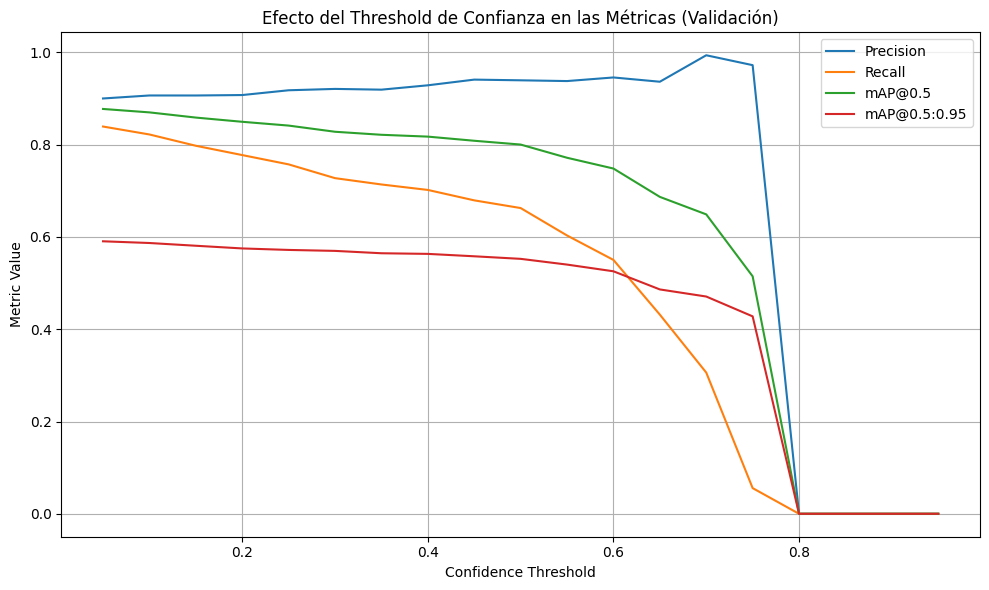

In [17]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

# === 1. Cargar el modelo entrenado ===
model = YOLO("/content/seals_2025/focas_prueba_3_4_2025_lr_00005_batch16_adamw_no_mosaic2/weights/best.pt")

# === 2. Definir ruta del dataset con división de validación ===
dataset_yaml = "/content/export_yolov8/data.yaml"  # Debe tener 'val' definido

# === 3. Evaluar el modelo sobre el conjunto de validación ===
print("=== MÉTRICAS GENERALES SOBRE VALIDACIÓN ===")
results = model.val(data=dataset_yaml, conf=0.25, iou=0.5)

# === 4. Métricas globales ===
# Obtenemos los promedios globales mediante mean_results() del objeto results.box.
# Esta función retorna: mp (precision promedio), mr (recall promedio),
# map50 (mAP@0.5) y mAP (mAP@0.5:0.95)
mp, mr, map50, mAP = results.box.mean_results()
print(f"Precision promedio: {mp:.4f}")
print(f"Recall promedio: {mr:.4f}")
print(f"mAP@0.5: {map50:.4f}")
print(f"mAP@0.5:0.95: {mAP:.4f}")

# === 5. Métricas por clase ===
# Definimos el diccionario de nombres de clase (ajusta según corresponda)
names = {0: 'hole', 1: 'seal'}
# results.box.maps es un array con el mAP (mAP@0.5:0.95) por cada clase
class_maps = results.box.maps

print("\n=== MÉTRICAS POR CLASE EN VALIDACIÓN ===")
for cls_map, name in zip(class_maps, names.values()):
    print(f"{name}: mAP50-95 = {cls_map:.4f}")

# === 6. Curva de métricas según confidence threshold ===
conf_values = [round(i * 0.05, 2) for i in range(1, 20)]  # De 0.05 a 0.95
precisions = []
recalls = []
maps50 = []
maps_val = []

print("\n=== CURVA DE MÉTRICAS SEGÚN CONFIDENCE (VALIDACIÓN) ===")
for conf in conf_values:
    print(f"Evaluando con conf = {conf}")
    res = model.val(data=dataset_yaml, split="val", conf=conf, iou=0.5, verbose=False)
    mp_conf, mr_conf, map50_conf, mAP_conf = res.box.mean_results()
    precisions.append(mp_conf)
    recalls.append(mr_conf)
    maps50.append(map50_conf)
    maps_val.append(mAP_conf)

# === 7. Graficar ===
plt.figure(figsize=(10, 6))
plt.plot(conf_values, precisions, label="Precision")
plt.plot(conf_values, recalls, label="Recall")
plt.plot(conf_values, maps50, label="mAP@0.5")
plt.plot(conf_values, maps_val, label="mAP@0.5:0.95")
plt.xlabel("Confidence Threshold")
plt.ylabel("Metric Value")
plt.title("Efecto del Threshold de Confianza en las Métricas (Validación)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [18]:
# 10. Guardar los resultados del experimento

# Define la carpeta de destino en Google Drive
dest_folder = "/content/drive/MyDrive/v46_6_4_2025/resultados_epoch39_6_4_2025/valid_porclases_solovaledela9ala27"
!mkdir -p "{dest_folder}"                                                           #El comando mkdir -p crea esa carpeta (y cualquier subcarpeta necesaria) si no existe.

# Copia la carpeta de resultados (ajusta el nombre según el que se haya generado)
!cp -r /content/runs/detect "{dest_folder}/"   #copiar los reultados del modelo en drive


# Comprueba que se copiaron los archivos (opcional)
!ls "{dest_folder}"                                                                 #verifica que los archivos se han copiado correctamente

# Opcional: comprimir la carpeta de resultados para descargarla a tu PC
#!zip -r /content/seals_2025/focas_prueba_snow.zip "{dest_folder}/focas_prueba_snow"   #Aquí se comprime la carpeta que acabas de copiar en Drive (la subcarpeta focas_training_prueba1_640_24_02_25 dentro de foquitas) en un archivo ZIP llamado foquitas.zip que se guarda en /content (la carpeta principal del entorno de Colab).

# Descargar el archivo ZIP a tu PC
#from google.colab import files
#files.download('/content/seals_2025/focas_prueba_snow.zip')

detect


In [20]:
from ultralytics import YOLO

# 1. Cargar el modelo entrenado
model = YOLO("/content/seals_2025/focas_prueba_3_4_2025_lr_00005_batch16_adamw_no_mosaic2/weights/best.pt")

# 2. Ejecutar la evaluación sobre el conjunto de test
results = model.val(data="/content/export_yolov8/data.yaml", split="test")

# 3. Mostrar las métricas principales
metrics = results.box  # Métricas de bounding boxes

print(f"mAP50:      {metrics.map50:.4f}")
print(f"mAP50-95:   {metrics.map:.4f}")
print(f"Precisión:  {metrics.mp:.4f}")
print(f"Recall:     {metrics.mr:.4f}")

# === TEST POR CLASE ===
# Definir el diccionario de nombres de clase (ajusta según corresponda)
names = {0: 'hole', 1: 'seal'}
# results.box.maps es un array con el mAP (mAP@0.5:0.95) por cada clase
class_maps = metrics.maps

print("\n=== TEST POR CLASE ===")
for cls_map, name in zip(class_maps, names.values()):
    print(f"{name}: mAP50-95 = {cls_map:.4f}")






Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/export_yolov8/test/labels.cache... 1169 images, 1002 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:03<00:00, 21.33it/s]


                   all       1169        179      0.835      0.707       0.79      0.488
                  hole        134        135      0.852      0.704      0.821      0.479
                  seal         41         44      0.817       0.71      0.759      0.497
Speed: 0.4ms preprocess, 1.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val29
mAP50:      0.7897
mAP50-95:   0.4880
Precisión:  0.8346
Recall:     0.7071

=== TEST POR CLASE ===
hole: mAP50-95 = 0.4787
seal: mAP50-95 = 0.4973


In [26]:
# 10. Guardar los resultados del experimento

# Define la carpeta de destino en Google Drive
dest_folder = "/content/drive/MyDrive/v46_6_4_2025/resultados_epoch39_6_4_2025/test/porclases_de32a50"
!mkdir -p "{dest_folder}"                                                           #El comando mkdir -p crea esa carpeta (y cualquier subcarpeta necesaria) si no existe.

# Copia la carpeta de resultados (ajusta el nombre según el que se haya generado)
!cp -r /content/runs/detect "{dest_folder}/"   #copiar los reultados del modelo en drive


# Comprueba que se copiaron los archivos (opcional)
!ls "{dest_folder}"                                                                 #verifica que los archivos se han copiado correctamente

# Opcional: comprimir la carpeta de resultados para descargarla a tu PC
#!zip -r /content/seals_2025/focas_prueba_snow.zip "{dest_folder}/focas_prueba_snow"   #Aquí se comprime la carpeta que acabas de copiar en Drive (la subcarpeta focas_training_prueba1_640_24_02_25 dentro de foquitas) en un archivo ZIP llamado foquitas.zip que se guarda en /content (la carpeta principal del entorno de Colab).

# Descargar el archivo ZIP a tu PC
#from google.colab import files
#files.download('/content/seals_2025/focas_prueba_snow.zip')                                             #Este comando abre una ventana de descarga para que puedas bajar el archivo ZIP a tu ordenador.

detect


=== MÉTRICAS GENERALES SOBRE TEST ===
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/export_yolov8/test/labels.cache... 1169 images, 1002 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:03<00:00, 22.26it/s]


                   all       1169        179      0.841       0.45      0.642       0.45
                  hole        134        135      0.905      0.422      0.668      0.449
                  seal         41         44      0.778      0.477      0.616       0.45
Speed: 0.4ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val32
Precision promedio: 0.8413
Recall promedio: 0.4497
mAP@0.5: 0.6420
mAP@0.5:0.95: 0.4498

=== MÉTRICAS POR CLASE EN TEST ===
hole: mAP50-95 = 0.4493
seal: mAP50-95 = 0.4503

=== CURVA DE MÉTRICAS SEGÚN CONFIDENCE (TEST) ===
Evaluando con conf = 0.05
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/test/labels.cache... 1169 images, 1002 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:03<00:00, 22.22it/s]


                   all       1169        179       0.85        0.7      0.756      0.492
Speed: 0.4ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val33
Evaluando con conf = 0.1
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/test/labels.cache... 1169 images, 1002 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:03<00:00, 22.34it/s]


                   all       1169        179      0.864      0.633      0.728      0.483
Speed: 0.4ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val34
Evaluando con conf = 0.15
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/test/labels.cache... 1169 images, 1002 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:03<00:00, 22.66it/s]


                   all       1169        179      0.855      0.562      0.694      0.467
Speed: 0.4ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val35
Evaluando con conf = 0.2
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/test/labels.cache... 1169 images, 1002 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:03<00:00, 22.56it/s]


                   all       1169        179      0.851      0.547      0.687      0.465
Speed: 0.4ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val36
Evaluando con conf = 0.25
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/test/labels.cache... 1169 images, 1002 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:03<00:00, 22.52it/s]


                   all       1169        179      0.841      0.506      0.666      0.453
Speed: 0.4ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val37
Evaluando con conf = 0.3
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/test/labels.cache... 1169 images, 1002 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:03<00:00, 23.15it/s]


                   all       1169        179      0.835      0.483      0.655       0.45
Speed: 0.4ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val38
Evaluando con conf = 0.35
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/test/labels.cache... 1169 images, 1002 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:03<00:00, 23.57it/s]


                   all       1169        179      0.844      0.465       0.65       0.45
Speed: 0.4ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val39
Evaluando con conf = 0.4
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/test/labels.cache... 1169 images, 1002 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:03<00:00, 23.26it/s]


                   all       1169        179      0.841       0.45      0.642       0.45
Speed: 0.4ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val40
Evaluando con conf = 0.45
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/test/labels.cache... 1169 images, 1002 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:03<00:00, 23.07it/s]


                   all       1169        179       0.87      0.412      0.632      0.461
Speed: 0.4ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val41
Evaluando con conf = 0.5
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/test/labels.cache... 1169 images, 1002 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:03<00:00, 23.22it/s]


                   all       1169        179      0.847      0.322      0.584      0.432
Speed: 0.4ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val42
Evaluando con conf = 0.55
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/test/labels.cache... 1169 images, 1002 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:03<00:00, 24.03it/s]


                   all       1169        179      0.848        0.3      0.574      0.425
Speed: 0.4ms preprocess, 1.3ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val43
Evaluando con conf = 0.6
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/test/labels.cache... 1169 images, 1002 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:03<00:00, 24.34it/s]


                   all       1169        179      0.846      0.288      0.568       0.42
Speed: 0.4ms preprocess, 1.3ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val44
Evaluando con conf = 0.65
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/test/labels.cache... 1169 images, 1002 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:03<00:00, 23.56it/s]


                   all       1169        179      0.891      0.202      0.544      0.402
Speed: 0.5ms preprocess, 1.3ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val45
Evaluando con conf = 0.7
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/test/labels.cache... 1169 images, 1002 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:03<00:00, 24.07it/s]


                   all       1169        179      0.833       0.12       0.48      0.359
Speed: 0.4ms preprocess, 1.4ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val46
Evaluando con conf = 0.75
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/test/labels.cache... 1169 images, 1002 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:03<00:00, 24.35it/s]


                   all       1169        179        0.5     0.0148      0.257      0.244
Speed: 0.5ms preprocess, 1.3ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val47
Evaluando con conf = 0.8
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/test/labels.cache... 1169 images, 1002 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:02<00:00, 24.78it/s]


                   all       1169        179          0          0          0          0
Speed: 0.6ms preprocess, 1.3ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val48
Evaluando con conf = 0.85
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/test/labels.cache... 1169 images, 1002 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:03<00:00, 24.41it/s]


                   all       1169        179          0          0          0          0
Speed: 0.5ms preprocess, 1.3ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val49
Evaluando con conf = 0.9
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/test/labels.cache... 1169 images, 1002 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:03<00:00, 24.48it/s]


                   all       1169        179          0          0          0          0
Speed: 0.5ms preprocess, 1.4ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val50
Evaluando con conf = 0.95
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8/test/labels.cache... 1169 images, 1002 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:02<00:00, 24.73it/s]


                   all       1169        179          0          0          0          0
Speed: 0.5ms preprocess, 1.3ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val51


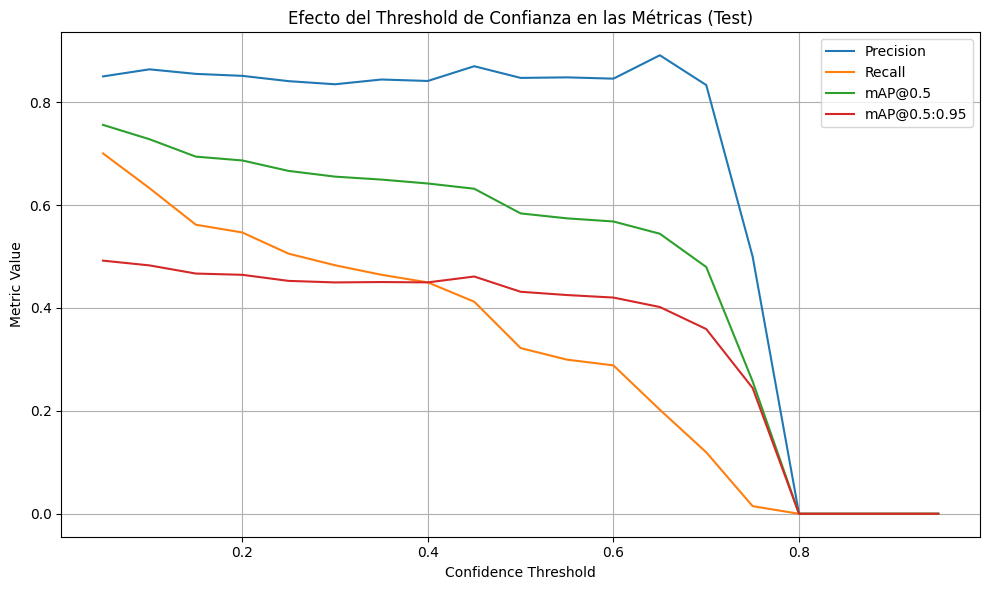

In [25]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

# === 1. Cargar el modelo entrenado ===
model = YOLO("/content/seals_2025/focas_prueba_3_4_2025_lr_00005_batch16_adamw_no_mosaic2/weights/best.pt")

# === 2. Definir ruta del dataset con división de test ===
dataset_yaml = "/content/export_yolov8/data.yaml"  # Debe tener la división 'test' definida

# === 3. Evaluar el modelo sobre el conjunto de test ===
print("=== MÉTRICAS GENERALES SOBRE TEST ===")
results = model.val(data=dataset_yaml, split="test", conf=0.4, iou=0.40)  # Ajusta conf e iou si lo necesitas

# === 4. Métricas globales ===
# Accedemos directamente a los atributos en lugar de llamarlos como funciones
print(f"Precision promedio: {results.box.mp:.4f}")
print(f"Recall promedio: {results.box.mr:.4f}")
print(f"mAP@0.5: {results.box.map50:.4f}")
print(f"mAP@0.5:0.95: {results.box.map:.4f}")

# === 5. Métricas por clase ===
print("\n=== MÉTRICAS POR CLASE EN TEST ===")
# Define manualmente el diccionario de nombres de clase (ajusta según corresponda)
names = {0: 'hole', 1: 'seal'}
# results.box.maps es un array con el mAP (mAP@0.5:0.95) por cada clase
class_maps = results.box.maps
for cls_map, name in zip(class_maps, names.values()):
    print(f"{name}: mAP50-95 = {cls_map:.4f}")

# === 6. Curva de métricas según confidence threshold ===
conf_values = [round(i * 0.05, 2) for i in range(1, 20)]  # De 0.05 a 0.95
precisions = []
recalls = []
maps50 = []
maps_val = []

print("\n=== CURVA DE MÉTRICAS SEGÚN CONFIDENCE (TEST) ===")
for conf in conf_values:
    print(f"Evaluando con conf = {conf}")
    res = model.val(data=dataset_yaml, split="test", conf=conf, iou=0.5, verbose=False)
    # Accedemos directamente a los atributos
    precisions.append(res.box.mp)
    recalls.append(res.box.mr)
    maps50.append(res.box.map50)
    maps_val.append(res.box.map)

# === 7. Graficar ===
plt.figure(figsize=(10, 6))
plt.plot(conf_values, precisions, label="Precision")
plt.plot(conf_values, recalls, label="Recall")
plt.plot(conf_values, maps50, label="mAP@0.5")
plt.plot(conf_values, maps_val, label="mAP@0.5:0.95")
plt.xlabel("Confidence Threshold")
plt.ylabel("Metric Value")
plt.title("Efecto del Threshold de Confianza en las Métricas (Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
